# **Original AI**

## **概要**

本プログラムは、画像分類用AIをPytorchを用いて作成するものです。

学習・分類データにはCifar-100 (https://www.cs.toronto.edu/~kriz/cifar.html) を使用します。

Cifar-100は100クラス分類用の画像データセットで、1クラスにつき600枚の画像セットが存在します。<br><br>

## **操作方法**

まず実行を始める前に、上の「ランタイム」から「ランタイムのタイプを変更」を選択して、「T4 GPU」に切り替えてください。

その後セルの一番上から順に実行していってください。<br><br>


注意点：

1.上から順に実行しなければメモリ不足が起こり実行が止まる可能性があります。必ず上から順番に実行してください。

2.AIの学習時に時間がかかるので気長にお待ちください。（30分前後かかります）<br>
  (実行時間を短くしたい場合には本ノートブックの目次から「学習」に移動し、そこの指示通りepoch数を小さくしてください)

3.Google ColabのGPU使用時間には制限があるので他にGPUを使用する予定がある場合には実行に十分注意してください。<br>（その場合は無理に実行せずにコードの閲覧のみしていただけると幸いです）<br><br>

## **制作者のコメント**

Cifar-100というクラス数が非常に多い分類タスクに取り組むにあたって、ChatGPT等を使用しながらモデル設計と出力の確認等を行いました。これまでの私が学んできたことを生かして層の調整等頑張りました。Google Colabのメモリ制限のこともあり、モデルサイズは制限されましたが、その中でできうる限りの工夫を施しました！

作成していく中で、インターネットの情報やChatGPTの出力を確認していくと、自分が作成したものに比べてclass設計がスマートだったり、引数等の使い方が上手であったりするものが多く、非常に勉強になりました。<br><br>
## **作成時間**

作成時間：**約100時間**<br>
(これまでのAI関連の勉強時間を含めると上記の時間を超えるはずです)

## ライブラリのインストールと読み込み

pytorchという機械学習ライブラリをインストールします。

In [ ]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

使用するライブラリをimportします

In [ ]:
%reset -f

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets, transforms

from tqdm import tqdm # 実行経過を可視化するライブラリ
import gc             # メモリ開放を行うためのライブラリ
import random
import os


#完全な再現性の確保ではないが、最低限のseed値固定
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
#複数回実行・検証することを考えてメモリを開放しておく
gc.collect()
torch.cuda.empty_cache()

## データ読み込みとデータ前処理

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") #様々な環境で使用できるようにGPUの使用可否をもとに使用するデバイスを変更する

In [ ]:
"""
定数宣言
"""
NUM_CLASSES = 100       #分類するクラス数

TRAINDATA_SIZE = 50000  #学習用データの枚数
TESTDATA_SIZE  = 10000  #テスト用データの枚数

BATCH_SIZE = 500        #一度の学習に使用するデータの数（データをいくつかに分割して学習することでメモリの節約や学習効率の向上を見込める）

In [ ]:
"""
対象データ(Cifar-100)の読み込みと前処理
"""

#前処理方法の定義（ここではgrayscaleとpytorch用データ型に変換）
trans = torchvision.transforms.Compose([torchvision.transforms.Grayscale(num_output_channels=1),
                                        torchvision.transforms.ToTensor(),
                                        torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.3), scale=(0.8, 0.9))])

data_path = "dataset"  #データをダウンロードするフォルダ名

#学習用データについての処理
trainset = datasets.CIFAR100(data_path, train=True, download=True, transform = trans)   #データのダウンロードと読み込み・前処理
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)  #データのBATCH_SIZEへの分割

#テスト用データについての処理
testset = datasets.CIFAR100(data_path, train=False, download=True, transform = trans)
testloader = torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

100%|██████████| 169001437/169001437 [00:08<00:00, 20161996.71it/s]


Extracting dataset/cifar-100-python.tar.gz to dataset
Files already downloaded and verified


## 分類モデルの(CNN)の作成

・本モデルで使用しているLeakyReLUとは以下のReLU関数を

$$
    ReLU(x) =
        \begin{cases}
            x  \quad (x \geqq 0) \\
            0  \quad (x < 0 )    \\
        \end{cases}
$$

　次のように負の数にも拡張したものです。aを割引率として

$$
    LeakyReLU(x) =
        \begin{cases}
            x  \quad (x \geqq 0) \\
            ax \quad (x < 0 )    \\
        \end{cases}
$$

　と表されます。

In [ ]:
class ConvBlock(nn.Module):
    """
    畳み込み層2層 + プーリング層1層　活性化関数LeakyReLUの畳み込みブロッククラス
    """
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.LeakyReLU(),
            nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.LeakyReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.cnn(x)

In [ ]:
class Dense(nn.Module):
    """
    全結合層2層　活性化関数LeakyReLU  25%dropoutの全結合層
    """
    def __init__(self, in_dim, out_dim=100):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim, 500),
            nn.LeakyReLU(),
            nn.Dropout(0.25),
            nn.Linear(500, out_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
class Network(nn.Module):

    """
    分類モデル本体

    勾配消失を防ぐために中間出力からも勾配を伝播させるので、最終出力層以外からも出力する
    """

    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.Conv1 = ConvBlock(in_dim, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)

        self.fc1 = Dense(64 * 16 * 16, num_classes)
        self.fc2 = Dense(128 * 8 * 8, num_classes)
        self.fc3 = Dense(256 * 4 * 4, num_classes)
        self.fc4 = Dense(512 * 2 * 2, num_classes)

    def forward(self, x):

        x = self.Conv1(x)
        out1 = x.clone().view(x.size(0), -1)
        out1 = self.fc1(out1)

        x = self.Conv2(x)
        out2 = x.clone().view(x.size(0), -1)  #全結合層にデータを入力するためにデータを一次元データ(正確には (batchsize, channe*height*width) )に変換
        out2 = self.fc2(out2)


        x = self.Conv3(x)
        out3 = x.clone().view(x.size(0), -1)
        out3 = self.fc3(out3)

        x = self.Conv4(x)
        out4 = x.view(x.size(0), -1)
        out4 = self.fc4(out4)

        return out1, out2, out3, out4

## **学習**

実行時間を短くしたい場合には次のセル内の「epoch」の値を小さくしてください。

epochが1増えるごとに約30秒学習時間が増加します。

In [ ]:
"""
約三十分かかるので実行の確認だけする場合はepoch数を1～10のような小さな値に変更してください
精度の確認をする場合にはデフォルト値のまま実行してください
"""
IN_DIM = 1 # gray scale化しているので入力は1次元
model_path = "model.pth"

epoch = 50  #ここの数値を小さくすることで実行時間を短くできます(1epochあたり30秒)
lr = 0.001

losses = []

model = Network(IN_DIM, NUM_CLASSES).to(device) #モデルの作成とモデルのDevice（基本GPU）上への移動
# model.load_state_dict(torch.load(model_path)) #モデルを一度学習した後追加学習させる場合の重みの読み込み

criterion = nn.CrossEntropyLoss() #誤差関数を指定(クロスエントロピー誤差)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)  #最適化手法を指定(Adam)

model.train()
for i in range(epoch):

  loss_sum = 0
  acc_sum = 0
  for x, y in tqdm(trainloader):
    x, y = x.to(device), y.to(device)

    out1, out2, out3, out4 = model(x)
    loss1, loss2, loss3, loss4 = criterion(out1,y), criterion(out2,y), criterion(out3,y), criterion(out4,y)

    a, b, c = 0.25, 0.5, 0.75                         #各lossの割引率（最終出力層から遠いほど割り引くように値を設定）
    loss = a * loss1 + b * loss2 + c * loss3 + loss4  #中間出力のlossも伝播させることで勾配消失を防ぐ

    optimizer.zero_grad() #勾配を0に初期化
    loss.backward()       #各レイヤーごとの勾配を計算(誤差逆伝播)
    optimizer.step()      #勾配に従って重みを更新

    loss_sum += loss

  #本epochでの平均lossを出力する
  losses.append(loss_sum / TRAINDATA_SIZE)
  print(f"epoch{i}'s train loss is {losses[i]}")

  #1度学習したモデルの重みを保存して、使いまわしを可能にする
  torch.save(model.state_dict(), model_path)

print("end train")

100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


epoch0's train loss is 0.009207172319293022


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


epoch1's train loss is 0.008936572819948196


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


epoch2's train loss is 0.008893825113773346


100%|██████████| 100/100 [00:32<00:00,  3.07it/s]


epoch3's train loss is 0.00881322380155325


100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


epoch4's train loss is 0.008767098188400269


100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


epoch5's train loss is 0.00868932344019413


100%|██████████| 100/100 [00:34<00:00,  2.94it/s]


epoch6's train loss is 0.008675509132444859


100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


epoch7's train loss is 0.00861654244363308


100%|██████████| 100/100 [00:34<00:00,  2.89it/s]


epoch8's train loss is 0.008578197099268436


100%|██████████| 100/100 [00:35<00:00,  2.78it/s]


epoch9's train loss is 0.008537488989531994


100%|██████████| 100/100 [00:34<00:00,  2.90it/s]


epoch10's train loss is 0.008505454286932945


100%|██████████| 100/100 [00:34<00:00,  2.89it/s]


epoch11's train loss is 0.008457474410533905


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


epoch12's train loss is 0.00842558965086937


100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


epoch13's train loss is 0.008350339718163013


100%|██████████| 100/100 [00:34<00:00,  2.87it/s]


epoch14's train loss is 0.008327072486281395


100%|██████████| 100/100 [00:32<00:00,  3.03it/s]


epoch15's train loss is 0.008308319374918938


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


epoch16's train loss is 0.008307929150760174


100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


epoch17's train loss is 0.008286119438707829


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


epoch18's train loss is 0.008206657133996487


100%|██████████| 100/100 [00:33<00:00,  3.03it/s]


epoch19's train loss is 0.008181028068065643


100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


epoch20's train loss is 0.00816997978836298


100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


epoch21's train loss is 0.008084493689239025


100%|██████████| 100/100 [00:35<00:00,  2.84it/s]


epoch22's train loss is 0.008069734089076519


100%|██████████| 100/100 [00:34<00:00,  2.87it/s]


epoch23's train loss is 0.008042683824896812


100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


epoch24's train loss is 0.007995662279427052


100%|██████████| 100/100 [00:32<00:00,  3.09it/s]


epoch25's train loss is 0.007998778484761715


100%|██████████| 100/100 [00:32<00:00,  3.09it/s]


epoch26's train loss is 0.008004168048501015


100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


epoch27's train loss is 0.007938312366604805


100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


epoch28's train loss is 0.007951013743877411


100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


epoch29's train loss is 0.00790760014206171


100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


epoch30's train loss is 0.007902918383479118


100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


epoch31's train loss is 0.00785626471042633


100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


epoch32's train loss is 0.007825709879398346


100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


epoch33's train loss is 0.00780499679967761


100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


epoch34's train loss is 0.007784136570990086


100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


epoch35's train loss is 0.007765349466353655


100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


epoch36's train loss is 0.007745128124952316


100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


epoch37's train loss is 0.0077361129224300385


100%|██████████| 100/100 [00:32<00:00,  3.12it/s]


epoch38's train loss is 0.007696529384702444


100%|██████████| 100/100 [00:34<00:00,  2.93it/s]


epoch39's train loss is 0.007736910600215197


100%|██████████| 100/100 [00:32<00:00,  3.03it/s]


epoch40's train loss is 0.007679970934987068


100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


epoch41's train loss is 0.007662867195904255


100%|██████████| 100/100 [00:31<00:00,  3.13it/s]


epoch42's train loss is 0.007615271955728531


100%|██████████| 100/100 [00:32<00:00,  3.12it/s]


epoch43's train loss is 0.007601352408528328


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


epoch44's train loss is 0.00756443664431572


100%|██████████| 100/100 [00:32<00:00,  3.12it/s]


epoch45's train loss is 0.007607756182551384


100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


epoch46's train loss is 0.00754654360935092


100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


epoch47's train loss is 0.007528723683208227


100%|██████████| 100/100 [00:31<00:00,  3.17it/s]


epoch48's train loss is 0.007534864358603954


100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


epoch49's train loss is 0.007530235219746828
end train


**lossの変化の可視化**

学習過程でのlossがどのように変化したかを可視化します。
縦軸がlossの値で横軸がepoch数です。

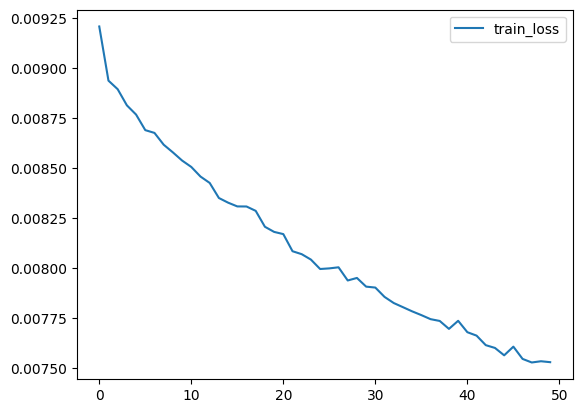

In [ ]:
x = torch.arange(0, epoch)
for i,val in enumerate(losses):
  losses[i] = val.to('cpu').detach().numpy().copy()

plt.plot(x, losses, label = "train_loss")

# 凡例の表示
plt.legend()

# プロット表示(設定の反映)
plt.show()

## **メモリ開放**

（CPU・GPU上のデータを削除し、メモリを開放することで削除分のメモリを使用可能にし、

モデルの評価時や可視化時に実行が止まってしまう可能性を防止する）

In [ ]:
del model, x, y
gc.collect()
torch.cuda.empty_cache()

## **モデル評価**

ランダムにラベル付けを行った場合の正答率の期待値は1%なので、学習がよく進んでいることがわかります。(50epoch)

In [ ]:
loss_sum = 0
acc = 0

model_path = "model.pth"
model = Network(IN_DIM, NUM_CLASSES).to(device)
model.load_state_dict(torch.load(model_path))

print("start pred")

for x, y in tqdm(testloader):
  x, y = x.to(device), y.to(device)
  _, _, _, outputs = model(x)

  for i in range(BATCH_SIZE):
    if y[i] == torch.argmax(outputs[i]):
      acc+=1

print(f"\ntest accuracy is {acc / 10000}")

start pred


100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


test accuracy is 0.5492


## 可視化

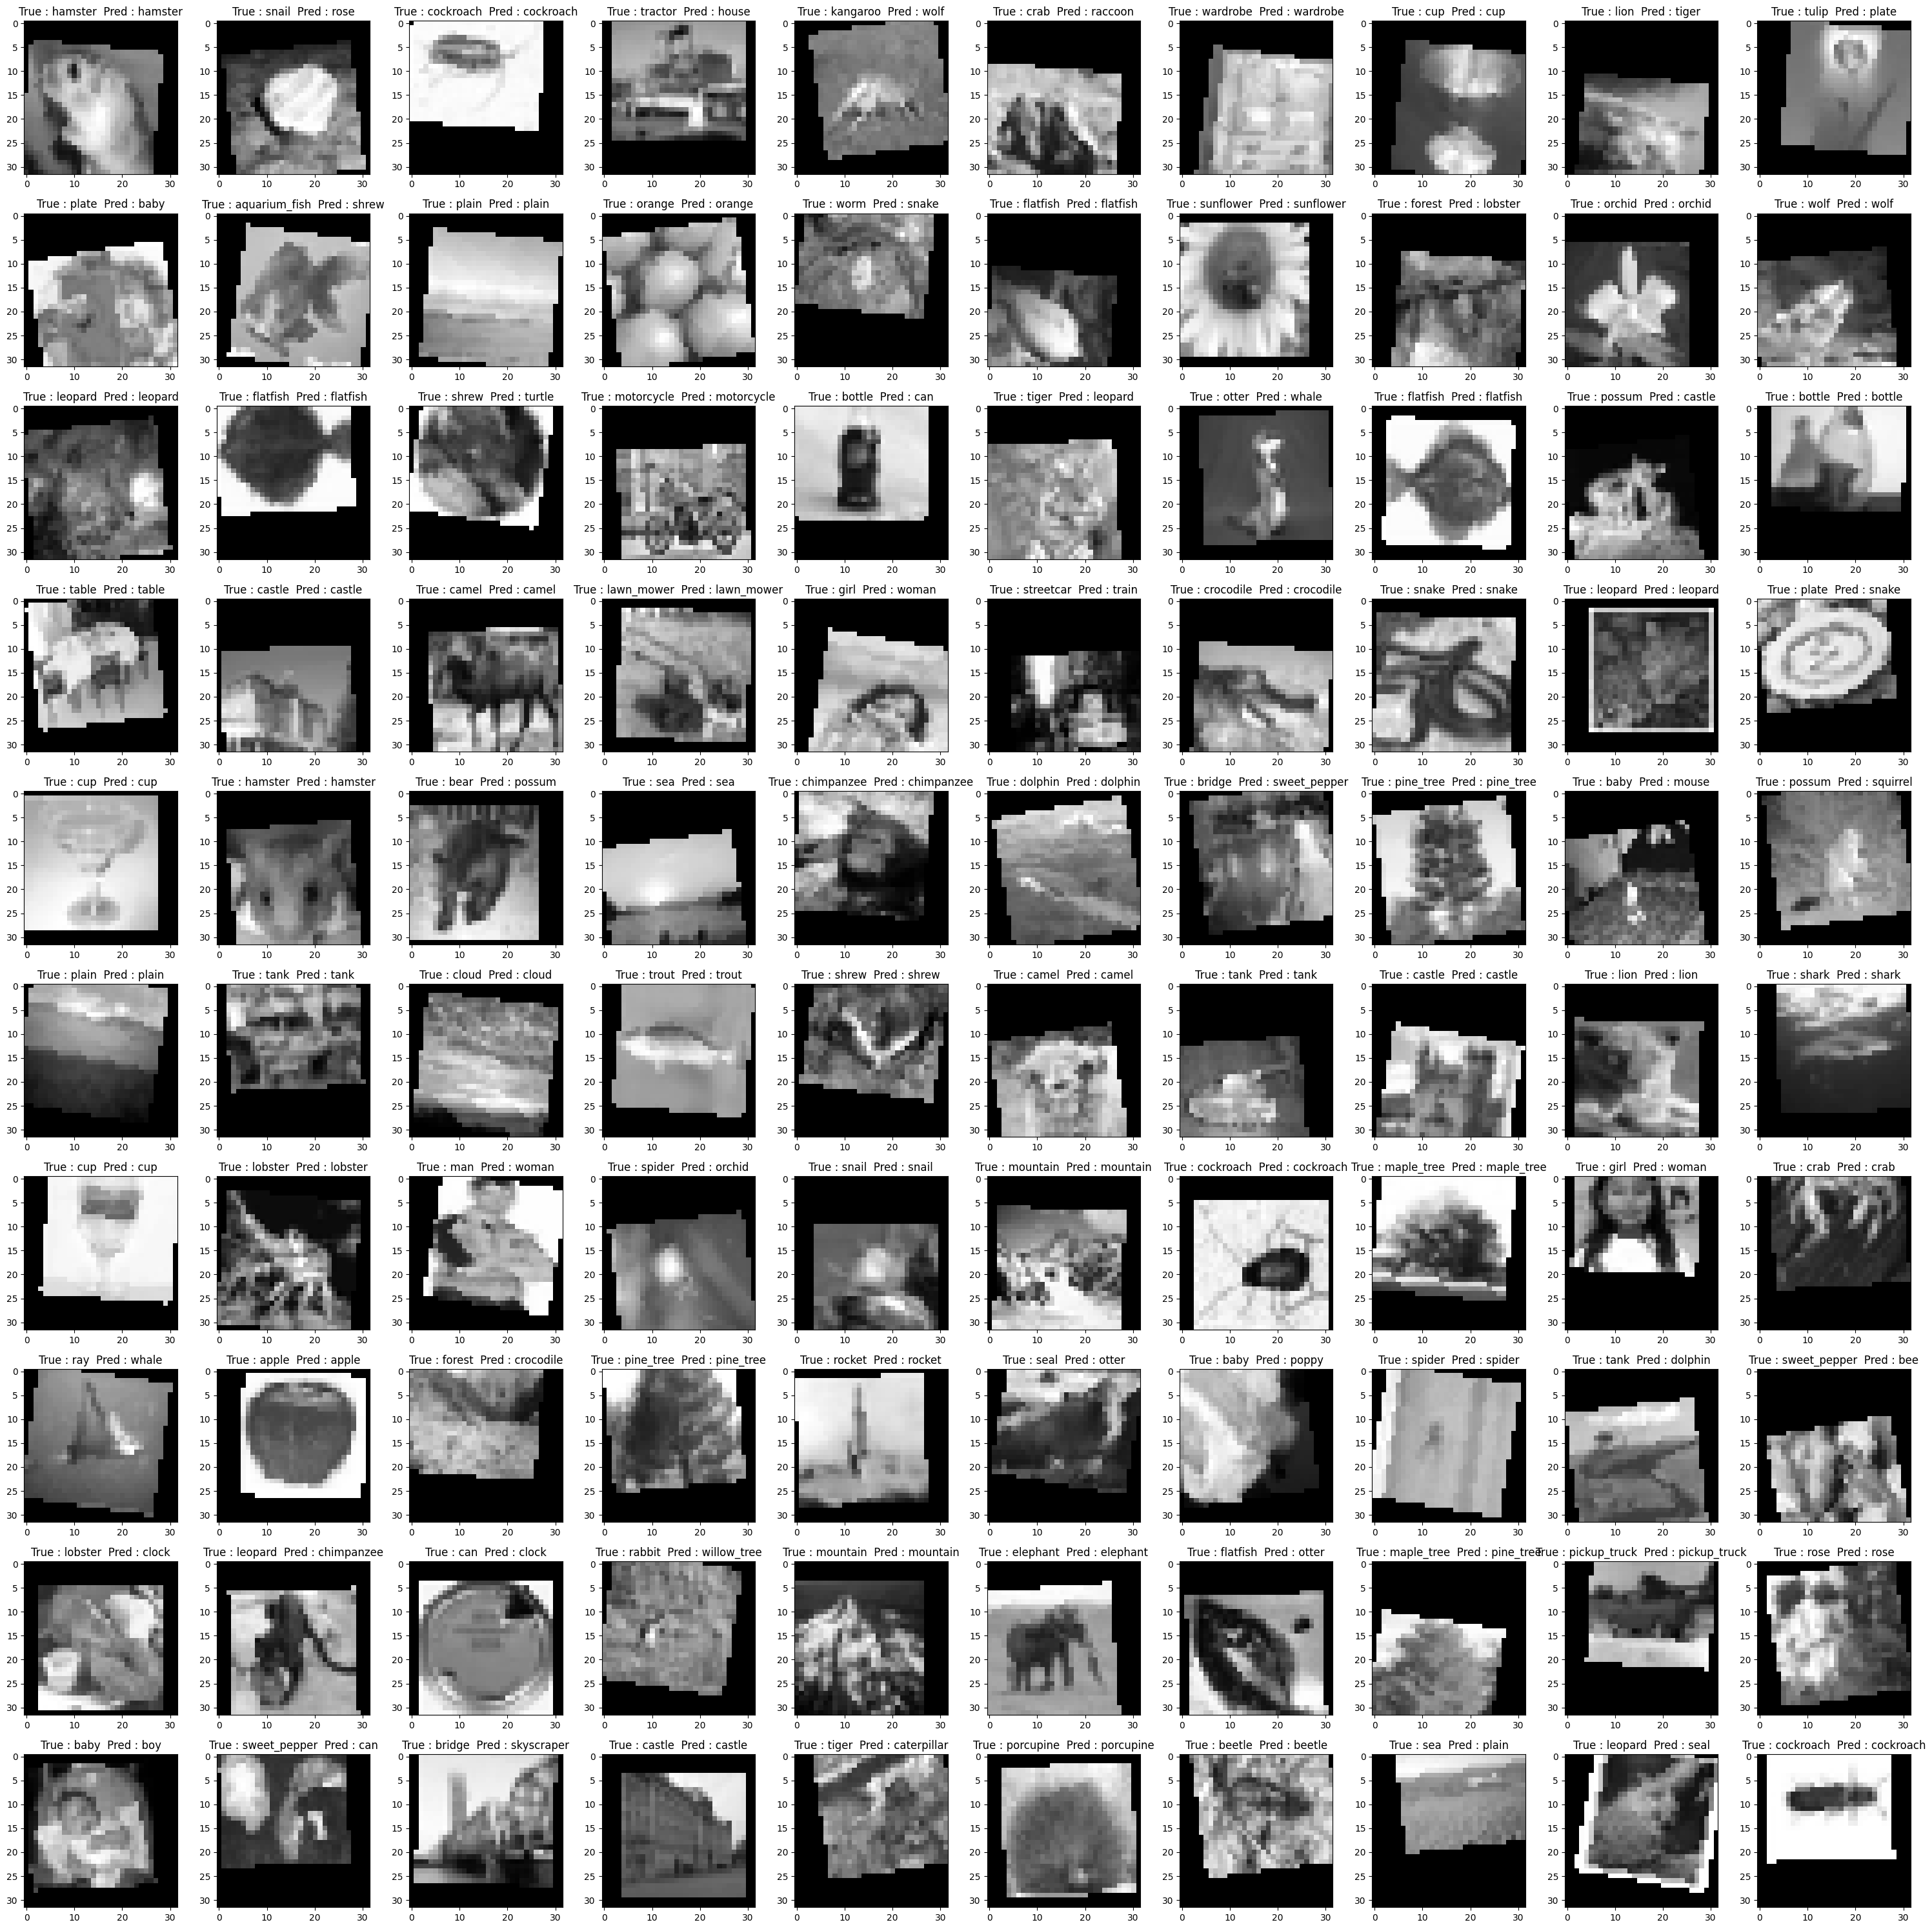

In [ ]:
LABELS = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]


for x, y in testloader:
  x,y = x.to(device), y.to(device)
  _, _, _, outputs = model(x)
  fig, axes = plt.subplots(10, 10, figsize=(30,30), tight_layout=True)

  #入力データのうち100枚を可視化する
  for i in range(10):
    for j in range(10):
      x_per = torch.permute(x[i*10+j], (1, 2, 0))  #pytorchではデータの順番が(channel(色情報), height, width)になっているのでplot用に並び替える

      axes[i,j].imshow(x_per.to("cpu"), cmap = "gray")

      true = y[i*10+j].item()

      pred = torch.argmax(outputs[i*10 + j])

      axes[i,j].set_title(f"True : {LABELS[true]}  Pred : {LABELS[pred]}")
  plt.show()
  break